In [1]:
!nvidia-smi

Tue Dec 11 17:04:39 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 10%   48C    P8    19W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 39%   58C    P8    22W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_VISIBLE_DEVICES=0,1


In [3]:
from fastai import *
from fastai.vision import *
import pathlib

In [4]:
bs = 32

In [5]:
path = pathlib.Path('/media/ssd_working_space/karmanya/data/armbarvsheelhookclean/')

In [6]:
for c in ['armbar', 'heelhook']:
    print(c)
    verify_images(path/'Test'/c, delete=True, max_size=500)

armbar


heelhook


In [12]:
images = ImageDataBunch.from_folder(path, train='Train', valid='Test', ds_tfms=get_transforms(), size=224,
                                    bs=bs).normalize(imagenet_stats)

In [13]:
images.classes

['armbar', 'heelhook']

In [14]:
images.export()

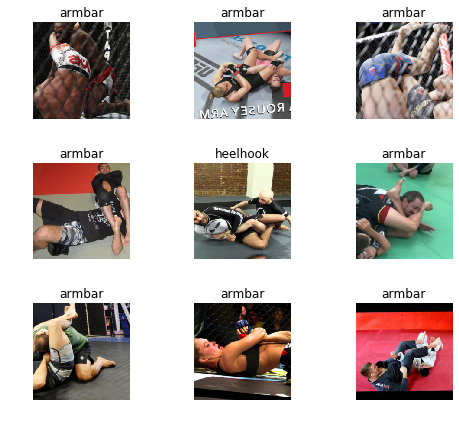

In [9]:
images.show_batch(rows=3, figsize=(7,6))

In [ ]:
?learn.save

In [10]:
learn = create_cnn(images, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.947060,0.446368,0.197279
2,0.787252,0.294912,0.136054
3,0.674709,0.254922,0.112245
4,0.591862,0.241487,0.102041


In [12]:
learn.save('armbarvsheelhookstage1')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

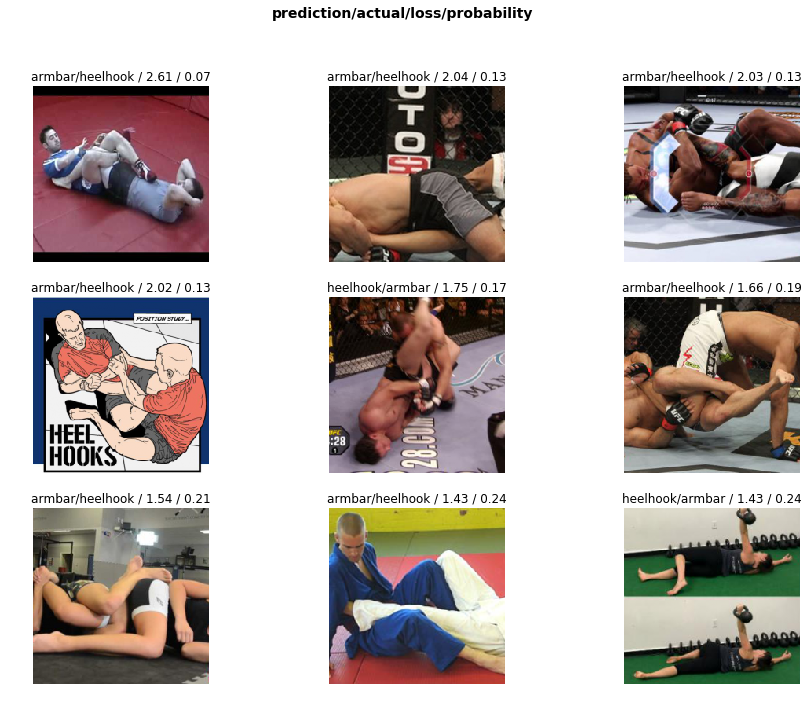

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

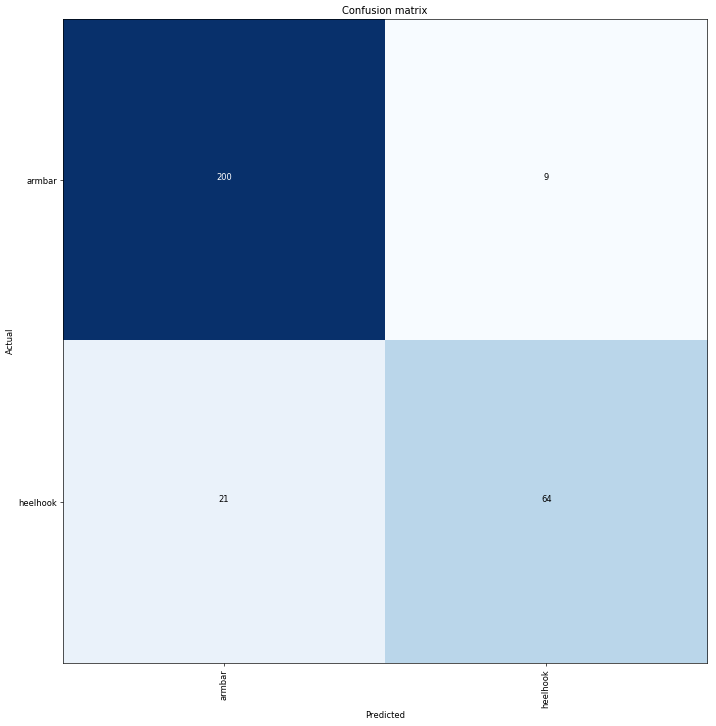

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
interp.most_confused(min_val=2)

[('heelhook', 'armbar', 21), ('armbar', 'heelhook', 9)]

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.702997,0.364913,0.125850


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


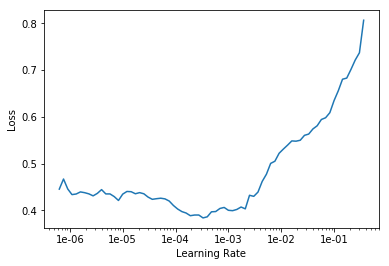

In [20]:
learn.recorder.plot()

In [ ]:
learn.save('armbarvsheelhookpostunfreeze', return_path=True)

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

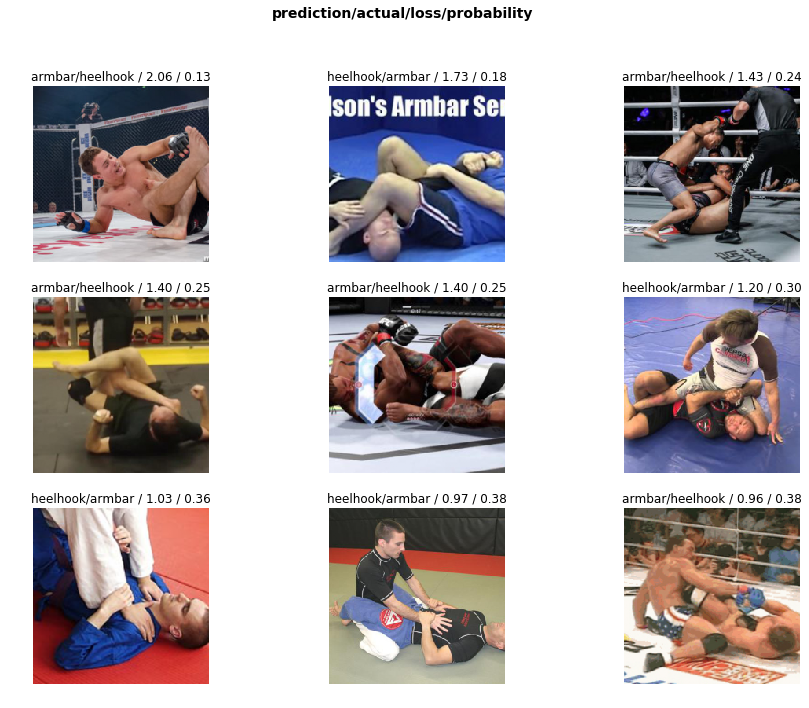

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

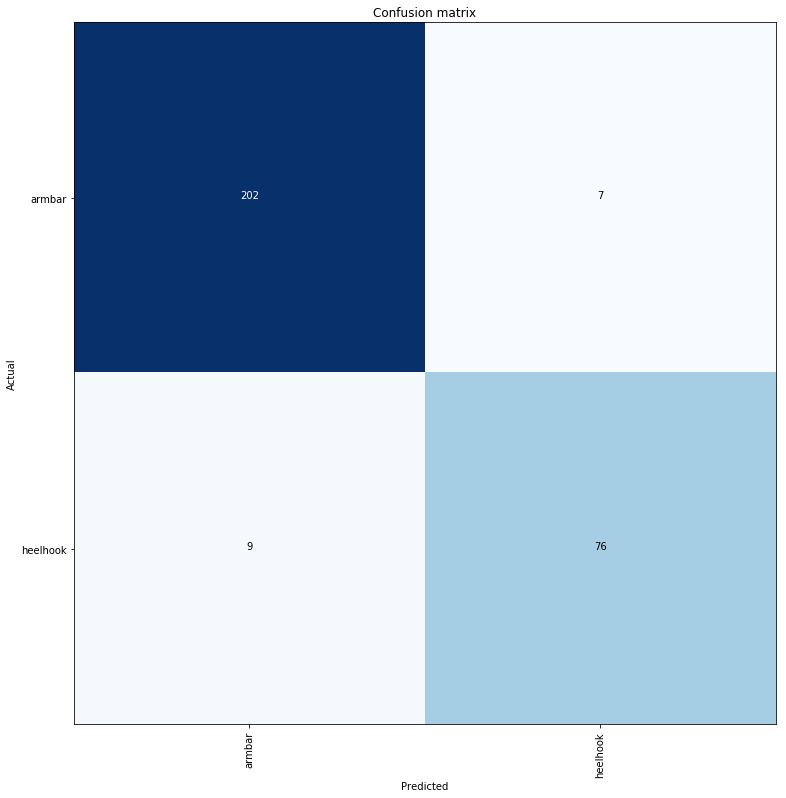

In [26]:
interp.plot_confusion_matrix(figsize=(11,11))

In [27]:
re50 = create_cnn(images, models.resnet50, metrics=error_rate)

In [28]:
re50.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.817924,0.708609,0.377551
2,0.755336,0.408628,0.187075
3,0.653747,0.279404,0.105442
4,0.550788,0.171081,0.068027
5,0.481058,0.164740,0.051020
6,0.423037,0.155342,0.047619
7,0.375512,0.147955,0.051020
8,0.346680,0.142323,0.047619


In [29]:
interp = ClassificationInterpretation.from_learner(re50)

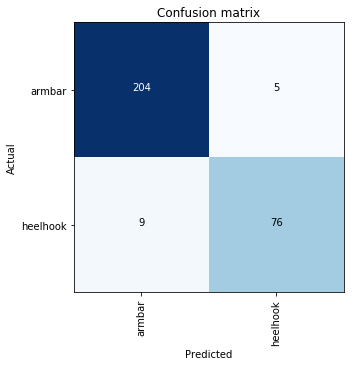

In [30]:
interp.plot_confusion_matrix(figsize=(5,5))

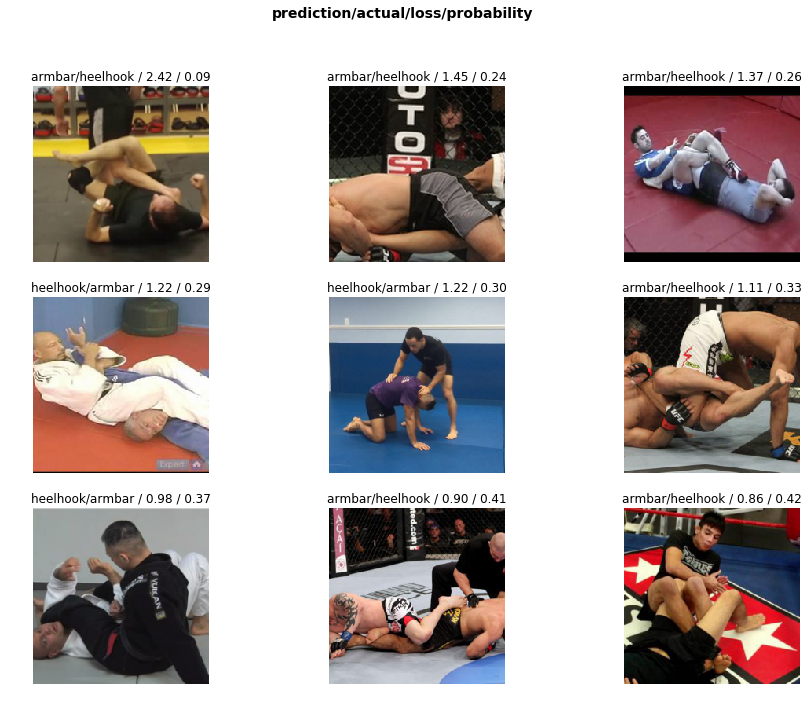

In [31]:
interp.plot_top_losses(9, figsize=(15,11))

In [32]:
re50.save('res50armbarvsheelhookperfect')

In [33]:
re50.unfreeze()

In [34]:
re50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


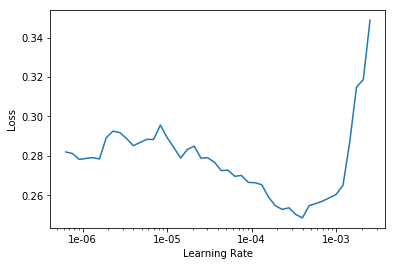

In [35]:
re50.recorder.plot()

In [36]:
re50.fit_one_cycle(8, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.270023,0.144056,0.040816
2,0.267763,0.137726,0.034014
3,0.259406,0.128881,0.037415
4,0.251190,0.124004,0.034014
5,0.240168,0.119424,0.030612
6,0.235685,0.117230,0.030612
7,0.222228,0.115574,0.027211
8,0.219863,0.115293,0.023810


In [37]:
interp = ClassificationInterpretation.from_learner(re50)

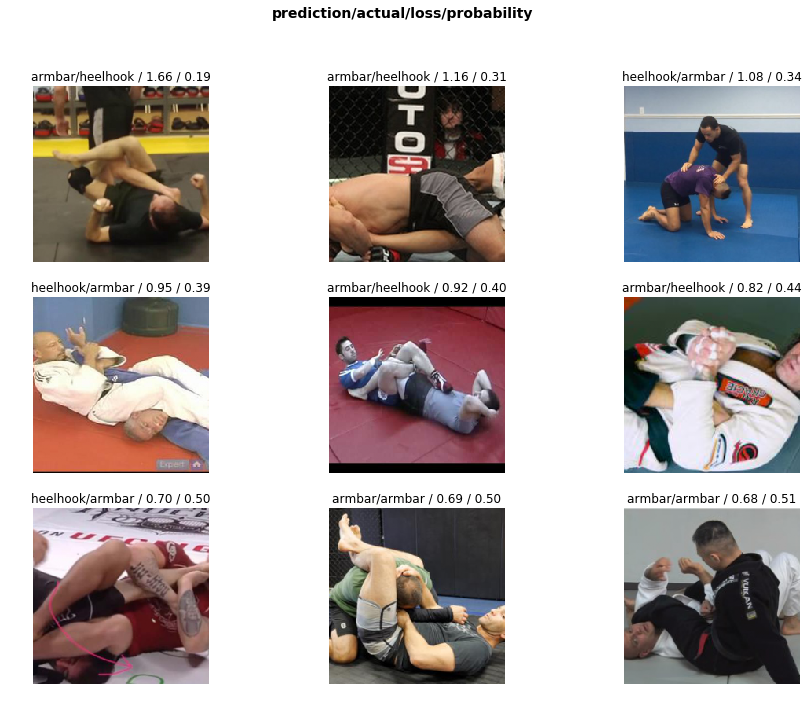

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

In [115]:
ClassificationInterpretation.plot_top_losses??

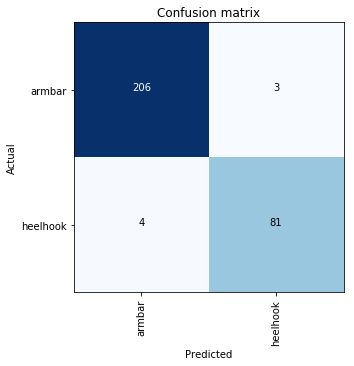

In [39]:
interp.plot_confusion_matrix(figsize=(5,5))

In [37]:
sd = LabelLists.load_empty(path/'export.pkl', tfms=get_transforms(), size=224).add_test_folder('armbarheelhookunlabel')

In [50]:
sd.test

LabelList
y: CategoryList (11 items)
[None, None, None, None, None]...
Path: /media/ssd_working_space/karmanya/data/armbarvsheelhookclean
x: ImageItemList (11 items)
[Image (3, 960, 1280), Image (3, 960, 1280), Image (3, 960, 1280), Image (3, 960, 1280), Image (3, 960, 1280)]...
Path: /media/ssd_working_space/karmanya/data/armbarvsheelhookclean

In [51]:
empty_data = sd.databunch().normalize(imagenet_stats)

In [57]:
empty_data.test_ds

LabelList
y: CategoryList (11 items)
[None, None, None, None, None]...
Path: /media/ssd_working_space/karmanya/data/armbarvsheelhookclean
x: ImageItemList (11 items)
[Image (3, 960, 1280), Image (3, 960, 1280), Image (3, 960, 1280), Image (3, 960, 1280), Image (3, 960, 1280)]...
Path: /media/ssd_working_space/karmanya/data/armbarvsheelhookclean

In [40]:
re50 = create_cnn(empty_data, models.resnet50).load('res50armbarvsheelhookperfect')

In [42]:
preds,y = re50.get_preds(ds_type=DatasetType.Test)

In [60]:
empty_data.classes

['armbar', 'heelhook']

In [109]:
preds

tensor([[0.9764, 0.0236],
        [0.8503, 0.1497],
        [0.9927, 0.0073],
        [0.7872, 0.2128],
        [0.5376, 0.4624],
        [0.7770, 0.2230],
        [0.8286, 0.1714],
        [0.9494, 0.0506],
        [0.9172, 0.0828],
        [0.6486, 0.3514],
        [0.9988, 0.0012]])

In [76]:
preds[:,1]

tensor([0.0236, 0.1497, 0.0073, 0.2128, 0.4624, 0.2230, 0.1714, 0.0506, 0.0828,
        0.3514, 0.0012])

In [81]:
pics = sd.lists[2].items
arm_bar = preds.to('cpu').detach().numpy()

df_preds = pd.DataFrame(np.column_stack((pics, arm_bar)),columns=['image', 'armbar','heelhook'])

In [91]:
image_0 = df_preds['image'][0]
df_preds

,image,armbar,heelhook
0,/media/ssd_working_space/karmanya/data/armbarv...,0.976371,0.0236287
1,/media/ssd_working_space/karmanya/data/armbarv...,0.850315,0.149685
2,/media/ssd_working_space/karmanya/data/armbarv...,0.992725,0.007275
3,/media/ssd_working_space/karmanya/data/armbarv...,0.787222,0.212778
4,/media/ssd_working_space/karmanya/data/armbarv...,0.537634,0.462366
5,/media/ssd_working_space/karmanya/data/armbarv...,0.777048,0.222952
6,/media/ssd_working_space/karmanya/data/armbarv...,0.828615,0.171385
7,/media/ssd_working_space/karmanya/data/armbarv...,0.949357,0.0506428
8,/media/ssd_working_space/karmanya/data/armbarv...,0.917227,0.0827732
9,/media/ssd_working_space/karmanya/data/armbarv...,0.648632,0.351368


In [103]:
for index, row in df_preds.iterrows():
    open_image(row['image'])
    print(f'Armbar Prob {row["armbar"]} HeelHook Prob {row["heelhook"]}')

Armbar Prob 0.9763714075088501 HeelHook Prob 0.023628661409020424
Armbar Prob 0.8503146171569824 HeelHook Prob 0.14968536794185638
Armbar Prob 0.9927250146865845 HeelHook Prob 0.007274999748915434
Armbar Prob 0.7872223258018494 HeelHook Prob 0.21277771890163422
Armbar Prob 0.5376336574554443 HeelHook Prob 0.4623663127422333
Armbar Prob 0.777047872543335 HeelHook Prob 0.22295211255550385
Armbar Prob 0.828615128993988 HeelHook Prob 0.17138490080833435
Armbar Prob 0.949357271194458 HeelHook Prob 0.05064275488257408
Armbar Prob 0.9172268509864807 HeelHook Prob 0.08277323096990585
Armbar Prob 0.6486319899559021 HeelHook Prob 0.3513680100440979
Armbar Prob 0.9988105297088623 HeelHook Prob 0.0011894578346982598


In [121]:
import matplotlib.pyplot as plt
import matplotlib.image as im
def plot_images_and_losses(df, figsize):
    "Show images in `df['image']` along with their prediction, probability of predicted class."
    fig,axes = plt.subplots(3,4,figsize=figsize)
    fig.suptitle('Armbar/Heelhook', weight='bold', size=14)
    for index, row in df.iterrows():
        ax = fig.add_subplot(3, 4, index+1)
        image = im.imread(row['image'])
        ax.imshow(image)
        ax.set_title(f'Armbar {row["armbar"]} Heelhook {row["heelhook"]}')

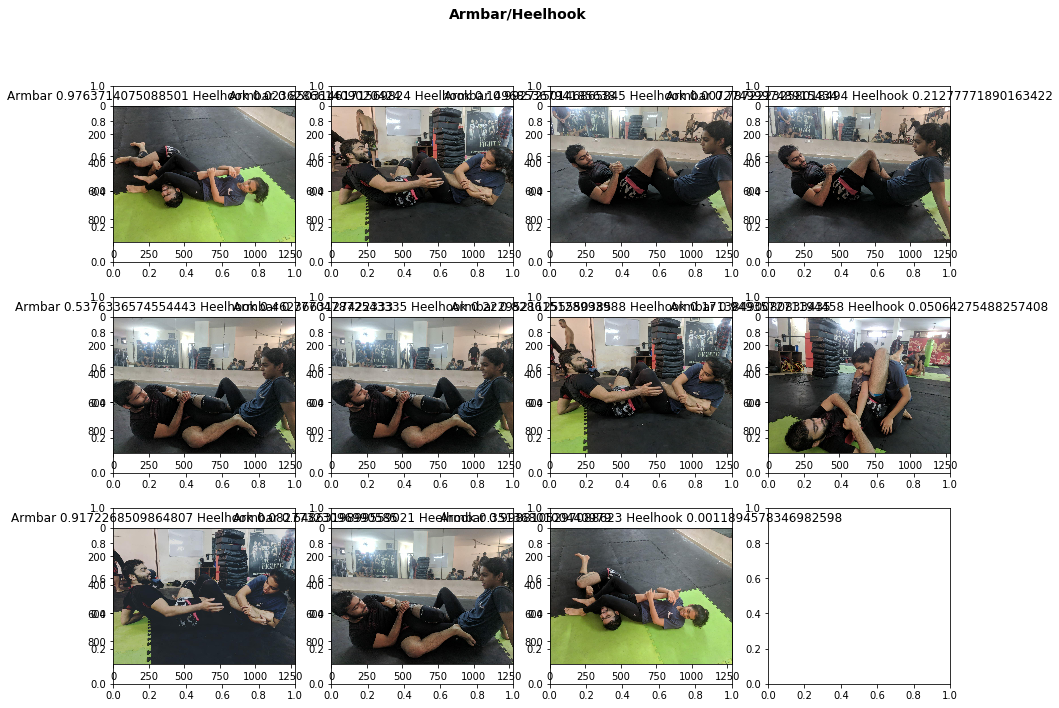

In [122]:
plot_images_and_losses(df_preds, figsize=(15,11))